In [1]:
import pandas as pd
loan=pd.read_csv('../.Database/merged_cleaned_loan.csv')
pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import seaborn as sns

In [2]:
loan = loan.dropna(subset=['state_unemployment'])

In [4]:
# Drop non-numerical columns from X
X=loan.drop(columns=['addr_state','emp_title','issue_d','loan_status','issue_d','issue_y','issue_m','title'])

# Drop annual_inc, to use log_annual_inc
X=X.drop(columns=['annual_inc'])

# Drop outcome variables from X
X=X.drop(columns=['loan_status_grouped','grade','sub_grade', 'int_rate'])

# Select outcome variable for Y
y=loan['loan_status_grouped']

def transform_emp_length(emp_length):
    if emp_length in ["< 1 year", "1 year"]:
        return "0-1 year"
    elif emp_length in ["2 years", "3 years", "4 years", "5 years"]:
        return "2-5 years"
    elif emp_length in ["6 years", "7 years", "8 years", "9 years", "10 years"]:
        return "6-10 years"
    elif emp_length == "10+ years":
        return "> 10 years"
    
X['emp_length'] = X['emp_length'].apply(transform_emp_length)

In [5]:
#Separate numerical and categorical columns
categorical_columns = ['home_ownership', 'term','purpose','emp_length']
numerical_columns = X.select_dtypes(include=['float64']).columns

# Apply OneHotEncoding to categorical columns before splitting
X_encoded = pd.get_dummies(X, columns=categorical_columns)

# Now perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Ensure the train and test sets have the same structure (dummies already handled)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Apply scaling to numerical columns
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# Drop rows with NaN values
X_train = X_train.dropna()
X_test = X_test.dropna()

# Ensure y_train matches X_train, y_test matches X_test
y_train = y_train[X_train.index]
y_test = y_test[X_test.index]

In [7]:
# Look for the optimal k value (probably should just check recall rate)
error_rate = []
for k in range(1 ,20):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    error_rate.append(1 - accuracy_score(y_test, y_pred)) 

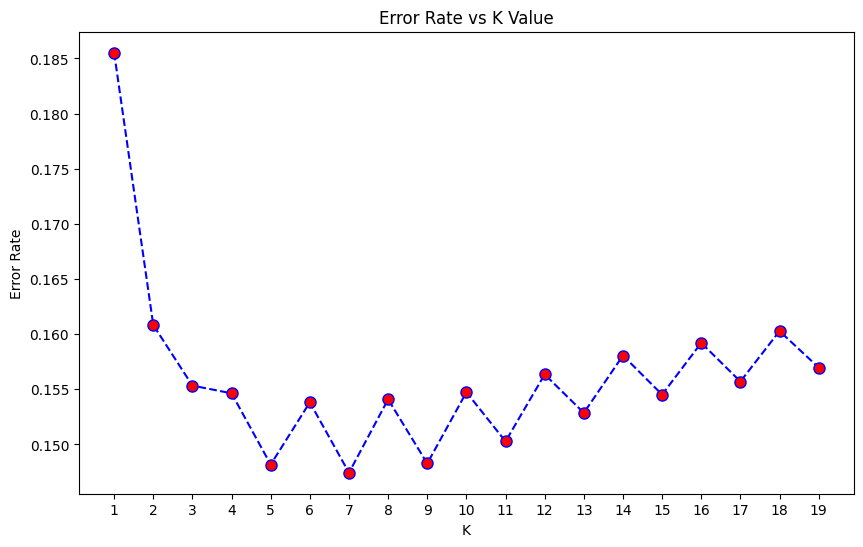

In [8]:
# Plotting the error rate vs k values
import numpy as np
plt.figure(figsize=(10,6))
plt.plot(range(1, 20), error_rate, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=8)
plt.title('Error Rate vs K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.xticks(np.arange(1, 20, 1))
plt.show()

In [9]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train,y_train)
pred_knn = knn.predict(X_test)
print("Classification Report :")
print(     classification_report(y_test,pred_knn))

Classification Report :
              precision    recall  f1-score   support

         0.0       0.85      0.98      0.91     40089
         1.0       0.88      0.38      0.53     11297

    accuracy                           0.85     51386
   macro avg       0.86      0.68      0.72     51386
weighted avg       0.86      0.85      0.83     51386



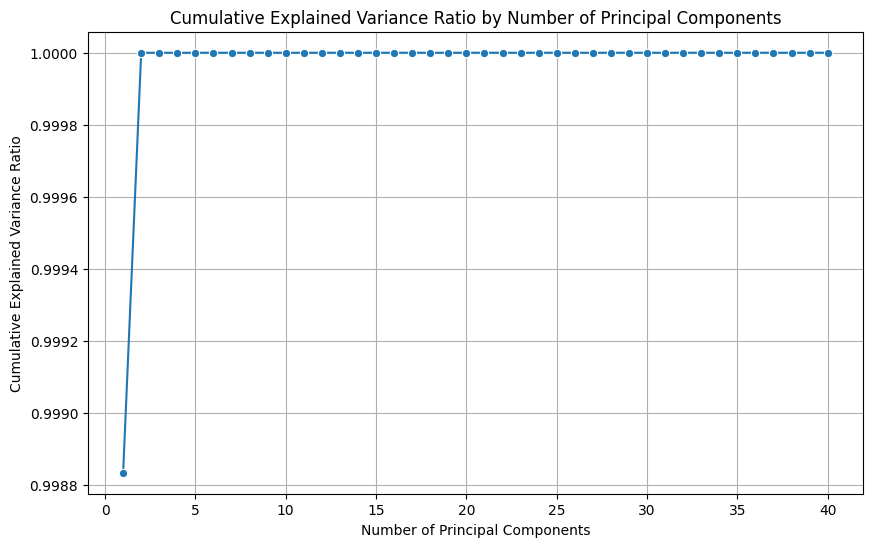

In [11]:
#Try PCA
pca = PCA(n_components=len(X_train.columns))
pca.fit(X_train)
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

cvr = pd.DataFrame({

    'Number of Principal Components': range(1, len(cumulative_variance_ratio) + 1),

    'Cumulative Explained Variance Ratio': cumulative_variance_ratio

})


plt.figure(figsize=(10, 6))
sns.lineplot(data=cvr,

             x='Number of Principal Components',

             y='Cumulative Explained Variance Ratio',

             marker='o') 

plt.title('Cumulative Explained Variance Ratio by Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [ 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf']
}

# Grid search to find the best parameters
# grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
# grid.fit(X_train, y_train)

# # Best parameters and accuracy
# print(grid.best_params_)
# print(grid.best_score_)

random_search = RandomizedSearchCV(SVC(), param_distributions=param_grid, n_iter=5, refit=True, verbose=2, random_state=42)
random_search.fit(X_train, y_train)

# Best parameters and accuracy
print(random_search.best_params_)
print(random_search.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time= 6.1min
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time= 6.2min
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time= 6.1min
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time= 6.1min
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time= 6.0min
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=27.4min
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=25.0min


In [36]:
svm_model = SVC(kernel='linear')  
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.92      0.96     10809
         1.0       0.98      1.00      0.99     40517

    accuracy                           0.98     51326
   macro avg       0.99      0.96      0.97     51326
weighted avg       0.98      0.98      0.98     51326

Confusion Matrix:
[[ 9958   851]
 [   84 40433]]


In [35]:
y_test

248914    1.0
95509     0.0
146705    1.0
99274     0.0
172020    0.0
         ... 
66089     1.0
47763     1.0
190194    1.0
16835     1.0
246572    1.0
Name: loan_status_grouped, Length: 51326, dtype: float64